This notebook performs model fitting and evaluating on hold out areas.

## init

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
dirs = [model_dir, scaler_dir, output_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

In [3]:
!gsutil cp gs://immap-wash-training/training/20200821_dataset.csv {data_dir}
df = pd.read_csv(data_dir + '20200821_dataset.csv').dropna()

Copying gs://immap-wash-training/training/20200821_dataset.csv...
/ [1 files][  7.6 MiB/  7.6 MiB]                                                
Operation completed over 1 objects/7.6 MiB.                                      


## fit

In [5]:
results = modelutils.fit_models(df, features, indicators, test_areas)

100%|██████████| 3/3 [04:01<00:00, 80.37s/it]


In [6]:
results.head()

,indicator,area,model,correlation,r2_score,mae,rmse
0,perc_hh_no_water_supply,bogot_dc,Ridge,0.366911,-0.009627,0.061207,0.109106
1,perc_hh_no_water_supply,norte_de_santander,Ridge,0.199039,-0.391915,0.111088,0.137023
2,perc_hh_no_water_supply,la_guajira,Ridge,0.291378,-0.196440,0.179152,0.251628
3,perc_hh_no_water_supply,nario,Ridge,0.733675,0.437542,0.098795,0.172711
4,perc_hh_no_water_supply,bogot_dc,RandomForestRegressor,0.317537,-0.358208,0.091287,0.126547


In [7]:
reorder_cols = ['indicator', 'area', 'model', 'mae', 'rmse', 'r2_score', 'correlation']
results[reorder_cols].groupby(['indicator', 'model']).mean()

mae      rmse  r2_score  \
indicator               model                                                 
perc_hh_no_sewage       RandomForestRegressor  0.137298  0.186503  0.198938   
                        Ridge                  0.160571  0.206029 -0.038754   
perc_hh_no_toilet       RandomForestRegressor  0.054115  0.093672  0.212656   
                        Ridge                  0.061758  0.103324  0.051989   
perc_hh_no_water_supply RandomForestRegressor  0.093308  0.139451  0.174869   
                        Ridge                  0.112560  0.167617 -0.040110   

                                               correlation  
indicator               model                               
perc_hh_no_sewage       RandomForestRegressor     0.470785  
                        Ridge                     0.486020  
perc_hh_no_toilet       RandomForestRegressor     0.489124  
                        Ridge                     0.389665  
perc_hh_no_water_supply RandomForestRegressor     0.511813  
                        Ridge                     0.397751

In [8]:
results[reorder_cols].groupby(['indicator', 'area']).mean()

mae      rmse  r2_score  \
indicator               area                                               
perc_hh_no_sewage       bogot_dc            0.094791  0.140728  0.050063   
                        la_guajira          0.236876  0.293725 -0.090853   
                        nario               0.117115  0.162258  0.610267   
                        norte_de_santander  0.146955  0.188352 -0.249109   
perc_hh_no_toilet       bogot_dc            0.026246  0.039727 -0.032441   
                        la_guajira          0.078937  0.121819  0.050913   
                        nario               0.068130  0.125670  0.451594   
                        norte_de_santander  0.058433  0.106777  0.059225   
perc_hh_no_water_supply bogot_dc            0.076247  0.117826 -0.183917   
                        la_guajira          0.164096  0.222960  0.045121   
                        nario               0.083750  0.148646  0.572446   
                        norte_de_santander  0.087644  0.124704 -0.164132   

                                            correlation  
indicator               area                             
perc_hh_no_sewage       bogot_dc               0.511848  
                        la_guajira             0.232247  
                        nario                  0.808624  
                        norte_de_santander     0.360890  
perc_hh_no_toilet       bogot_dc               0.361833  
                        la_guajira             0.306082  
                        nario                  0.759636  
                        norte_de_santander     0.330027  
perc_hh_no_water_supply bogot_dc               0.342224  
                        la_guajira             0.413997  
                        nario                  0.811728  
                        norte_de_santander     0.251180

In [9]:
df[indicators].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
perc_hh_no_water_supply,7421.0,0.077111,0.170809,0.0,0.001383,0.010172,0.051037,1.00
perc_hh_no_toilet,7421.0,0.056190,0.109878,0.0,0.007773,0.016949,0.048544,0.95
perc_hh_no_sewage,7421.0,0.166633,0.264022,0.0,0.005988,0.034691,0.186047,1.00


## predict

In [10]:
for indicator in tqdm(indicators):
    for model_type in ['RandomForestRegressor']:
        for area in test_areas:
            modelutils.predict_on_holdout(df, results, features, indicator, area, model_type)

100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


In [15]:
# Get top features of best model
indicator = 'perc_hh_no_toilet'
area = 'bogot_dc'
model_type = 'RandomForestRegressor'
modelutils.predict_on_holdout(df, results, features, indicator, area, model_type)

model = joblib.load(model_dir + indicator + '_' + area + '_' + model_type + '.pkl')
feature_importances = pd.DataFrame({'feature': features
                                    , 'importance': model.feature_importances_})
top_features = list(feature_importances.sort_values(by = 'importance', ascending = False).head(20)['feature'])
print(top_features)

['lag_aridity_cgiarv2', 'nighttime_lights', 'lag_elevation', 'elevation', 'aridity_cgiarv2', 'lag_vegetation', 'nighttime_lights_area_mean', 'population', 'lag_temperature', 'temperature', 'vegetation', 'lag_nearest_waterway', 'nearest_waterway', 'lag_population', 'pixelated_urban_area_size', 'lag_nighttime_lights', 'distance_from_capital', 'lag_urban_index', 'distance_from_capital_outskirts', 'lag_nearest_highway']


## error analysis

In [ ]:
# consolidate hold out results to one df
files_ = [output_dir + f for f in os.listdir(output_dir)]

dfs = []
for f in files_:
    df = pd.read_csv(f)
    df.columns = ['adm1_name', 'id', 'geometry', 'y_true', 'y_pred']
    df['filename'] = f.split('/')[1].split('_')[3]
    dfs.append(df)

mega_df = pd.concat(dfs, axis = 0)
mega_df['absdiff'] = abs(mega_df['y_true'] - mega_df['y_pred'])
mega_df.to_csv('results_granular.csv', index= False)

count    1099.000000
mean        0.090078
std         0.112818
min         0.000157
25%         0.019003
50%         0.043796
75%         0.119800
max         0.744686
Name: absdiff, dtype: float64


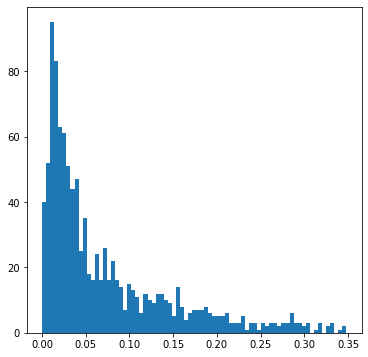

In [ ]:
srs = mega_df.loc[mega_df.filename == 'water', 'absdiff']
print(srs.describe())
pct = 0.35#srs.quantile(0.9)
import matplotlib.pyplot as plt
plt.grid(b=None)
srs[srs<pct].hist(bins = 75,grid=None,figsize=(6,6))

count    819.000000
mean       0.117376
std        0.142674
min        0.000034
25%        0.023146
50%        0.059097
75%        0.146308
max        0.698939
Name: absdiff, dtype: float64


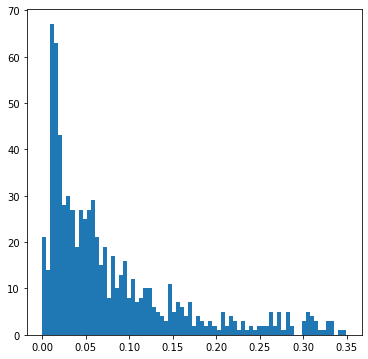

In [ ]:
srs = mega_df.loc[mega_df.filename == 'sewage', 'absdiff']
print(srs.describe())
pct = 0.35#srs.quantile(0.9)
import matplotlib.pyplot as plt
plt.grid(b=None)
srs[srs<pct].hist(bins = 75,grid=None,figsize=(6,6))

count    1099.000000
mean        0.047495
std         0.080486
min         0.000002
25%         0.011352
50%         0.019999
75%         0.049033
max         0.708308
Name: absdiff, dtype: float64


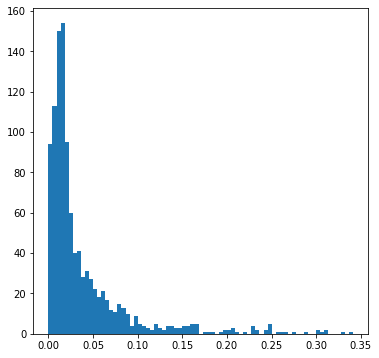

In [ ]:
srs = mega_df.loc[mega_df.filename == 'toilet', 'absdiff']
print(srs.describe())
pct = 0.35#srs.quantile(0.9)
import matplotlib.pyplot as plt
plt.grid(b=None)
srs[srs<pct].hist(bins = 75,grid=None,figsize=(6,6))